 # Import packages needed.

In [1]:
import tushare as ts
import datetime
import matplotlib.pyplot as plt
import numpy as np
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential

Using TensorFlow backend.


# Define a 'Stock' class.

In [2]:
class Stock:
    def __init__(self,code,balance=10000,price = 1.0,hold = 0):
        self.code = code
        self.balance = balance
        self.price = price
        self.hold = hold
        self.total = balance + price * hold

    def update(self,price=0.0):
        self.price = price
        self.total = self.balance + self.hold*price

    def buy(self):
        price = self.price
        inc_hold = np.floor(self.balance/price)
        self.hold +=  inc_hold
        self.balance -= inc_hold*price

    def sell(self):
        price = self.price
        hold = self.hold
        self.balance += hold*price
        self.hold = 0

    def __str__(self):
        return 'Trading:\ncode = %s\nbalance = %d\nprice = %f\nhold = %d\ntotal = %d'%(self.code,self.balance,self.price,self.hold,self.total)



# Define functions to load data and do preprocessing

In [3]:
def get_data(code,end='2017-01-01', duration=365):
    d1 = datetime.datetime.strptime(end,'%Y-%m-%d')
    d2 = d1 - datetime.timedelta(days=duration)
    start = d2.strftime('%Y-%m-%d')
    return ts.get_h_data(code, start=start, end=end)

In [4]:
def train_test_split(data,SEQ_LENGTH = 25,test_prop=0.3):
    data = data.sort_index()
    ntrain = int(len(data) *(1-test_prop))
    predictors = data.columns[:4]
    #norms = data[predictors].apply(np.linalg.norm)
    data_pred = data[predictors] #/norms
    num_attr = data_pred.shape[1]
    result = np.empty((len(data) - SEQ_LENGTH - 1, SEQ_LENGTH, num_attr))
    y = np.empty(len(data) - SEQ_LENGTH - 1)
    yopen = np.empty(len(data) - SEQ_LENGTH - 1)

    for index in range(len(data) - SEQ_LENGTH - 1):
        result[index, :, :] = data_pred[index: index + SEQ_LENGTH]
        y[index] = data.iloc[index + SEQ_LENGTH + 1].close
        yopen[index] = data.iloc[index + SEQ_LENGTH + 1].open

    xtrain = result[:ntrain, :, :]
    ytrain = y[:ntrain]
    xtest = result[ntrain:, :, :]
    ytest = y[ntrain:]
    ytest_open = yopen[ntrain:]
    return xtrain, xtest, ytrain, ytest, ytest_open

# Define a function to train a LSTM model

In [5]:
def train_model(xtrain,ytrain,SEQ_LENGTH=25,N_HIDDEN=256):
    # SEQ_LENGTH = 25  # Sequence Length, or # of days of trading
    # N_HIDDEN = 256  # Number of units in the hidden (LSTM) layers
    # num_attr = 4  # Number of predictors used for each trading day
    num_attr = xtrain.shape[2]
    model = Sequential()
    model.add(LSTM(N_HIDDEN, return_sequences=True, activation='tanh', input_shape=(SEQ_LENGTH, num_attr)))
    model.add(Dropout(0.2))
    model.add(LSTM(N_HIDDEN, return_sequences=False, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))
    model.compile(loss="mean_squared_error", optimizer='adam')  ## optimizer = 'rmsprop'
    model.fit(xtrain, ytrain, batch_size=50, epochs=20, validation_split=0.05)
    return model

# Do predictions on test data

In [6]:
def predict(model,xtest):
    predicted = model.predict(xtest)
    return predicted

# Develop a strategy to buy or sell a stock

In [7]:
def policy(code,xtest,ytest,ytest_open,model):
    ypred = model.predict(xtest)

    ### the first day
    xnow = xtest[0]
    price = xnow[-1,2]
    stock = Stock(code,price=price)
    pred_price = ypred[0,0]
    totals = [stock.total]

    for i in range(1,len(xtest)):
        price_open = ytest_open[i]
        price_close = ytest[i]
        stock.update(price=price_open)
        pred_price_now = ypred[i,0]
        if pred_price_now >= pred_price:
            stock.buy()
        else:
            stock.sell()
        pred_price = pred_price_now
        stock.update(price=price_close)
        totals.append(stock.total)

    plt.plot(totals)
    plt.title('Wealth curve')
    plt.show()
    return totals


# One Example

## get the stock information

In [8]:
code = '300222'
df = ts.get_stock_basics()
print df.ix[code][['name', 'industry', 'timeToMarket']]

name                科大智能
industry            电气设备
timeToMarket    20110525
Name: 300222, dtype: object


## download data in the past 1000 days from today

In [9]:
stock = Stock(code)
today = datetime.datetime.today().strftime('%Y-%m-%d')
data = get_data(code, end=today, duration=1000)
print '\n'
print {'data.shape':data.shape}
data[:5]

[Getting data:]###########

/Users/jinzhu/anaconda2/lib/python2.7/site-packages/tushare/stock/trading.py:447: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  df = df.sort('date', ascending=False)




{'data.shape': (508, 6)}


,open,high,close,low,volume,amount
date,,,,,,
2017-03-24,26.46,27.18,26.95,26.41,24010161.0,6.441153e+08
2017-03-23,27.31,27.32,26.72,25.82,35599750.0,9.496881e+08
2017-03-22,27.25,27.94,27.55,27.12,28774419.0,7.896619e+08
2017-03-21,27.29,27.75,27.63,27.09,30722765.0,8.441071e+08
2017-03-20,27.62,27.76,27.49,26.80,37351228.0,1.019667e+09


## look at the close price in the past 1000 days

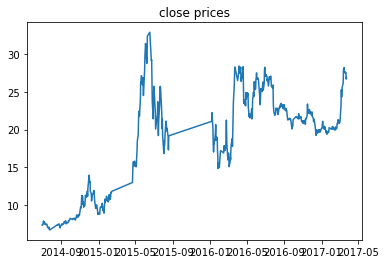

In [10]:
plt.plot(data.close)
plt.title('close prices')
plt.show()

## prepare data for LSTM model

In [11]:
xtrain, xtest, ytrain, ytest, ytest_open = train_test_split(data)
print {'xtrain.shape':xtrain.shape, 'xtest.shape':xtest.shape}
print {'ytrain.shape':ytrain.shape, 'ytest.shape':ytest.shape}

{'xtest.shape': (127, 25, 4), 'xtrain.shape': (355, 25, 4)}
{'ytrain.shape': (355,), 'ytest.shape': (127,)}


## train the LSTM model now:

In [12]:
model = train_model(xtrain,ytrain)

Train on 337 samples, validate on 18 samples
Epoch 1/20
337/337 [==============================] - 3s - loss: 1159.9461 - val_loss: 375.6049
Epoch 2/20
337/337 [==============================] - 2s - loss: 248.1403 - val_loss: 56.5062

## predict the close prices on the trainning data

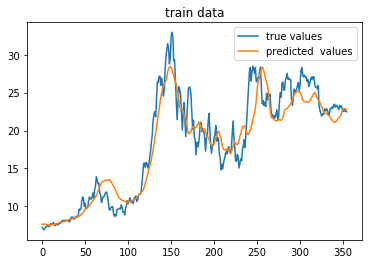

In [13]:
predicted_tr = model.predict(xtrain)
plt.plot(ytrain, label='true values')
plt.plot(predicted_tr, label='predicted  values')
plt.legend()
plt.title('train data')
plt.show()

## predict the close prices on the test data

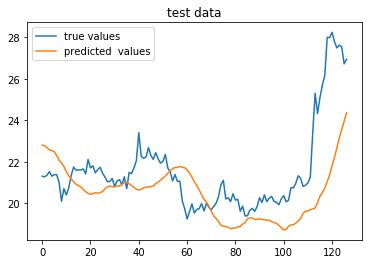

In [14]:
predicted_test = model.predict(xtest)
plt.plot(ytest, label='true values')
plt.plot(predicted_test, label='predicted  values')
plt.legend()
plt.title('test data')
plt.show()

## Look at the wealth curve by using the strategy we developed.

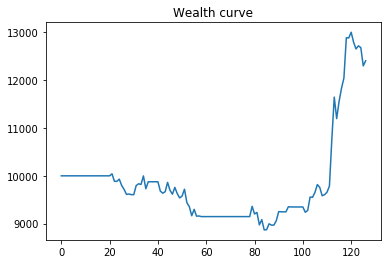

In [15]:
wealth = policy(code, xtest, ytest, ytest_open, model)
